In [ ]:
import numpy as np

from psi.controller import util
from psi.controller.calibration.util import load_calibration, psd, psd_df, db, dbtopa


In [1]:
%matplotlib inline
import pylab as plt

from psi import application as app
from psi.controller.calibration import tone
from psi.controller.calibration.api import FlatCalibration, PointCalibration
from psi.controller.calibration.util import load_calibration, psd, psd_df, db, dbi, dbtopa
from psi.core.enaml.api import load_manifest_from_file

frequencies = [1420, 2840, 11360]

engine_name = 'NI'
mic_channel_name = 'microphone'
speaker_channel_name = 'speaker'

io_file = app.get_default_io()
cal_file = app.get_default_calibration(io_file)

C:\Users\lbhb\miniconda3\envs\psi1\lib\site-packages\atom\scalars.py:228: FutureWarning: Unicode is deprecated and will be removed in atom 0.6.0, use Str instead.
  warnings.warn(FutureWarning(msg))


In [2]:
io_manifest = load_manifest_from_file(io_file, 'IOManifest')
io = io_manifest()
audio_engine = io.find(engine_name)
channels = audio_engine.get_channels(active=False)
load_calibration(cal_file, channels)

In [3]:
mic_channel = audio_engine.get_channel(mic_channel_name)
speaker_channel = audio_engine.get_channel(speaker_channel_name)
#print(mic_channel.gain)
#print(dbi(mic_channel.calibration.sensitivity))

expected_gains = speaker_channel.calibration.get_gain(frequencies, 80)
print(expected_gains)

[-19.66017394 -30.36617903 -23.90782839]


In [4]:
fixed_gain_result = tone.tone_sens(
    frequencies=frequencies,
    engine=audio_engine,
    ao_channel_name=speaker_channel_name,
    ai_channel_names=[mic_channel_name],
    gains=-30,
    debug=True,
    duration=0.1,
    iti=0,
    trim=0.01,
    repetitions=2,
)

In [7]:
fixed_gain_result.loc[mic_channel_name]['spl']

frequency
1420.0     80.169004
2840.0     84.842469
11360.0    76.120763
Name: spl, dtype: float64

In [8]:
tone_sens = fixed_gain_result.loc[mic_channel_name, 'sens']
calibration = PointCalibration(tone_sens.index, tone_sens.values)
gains = calibration.get_gain(frequencies, 80)

In [9]:
variable_gain_result = tone.tone_spl(
    frequencies=frequencies,
    engine=audio_engine,
    ao_channel_name=speaker_channel_name,
    ai_channel_names=[mic_channel_name],
    gains=gains,
    debug=True,
    duration=0.1,
    iti=0,
    trim=0.01,
    repetitions=2,
)

variable_gain_result['spl']

channel_name  frequency
microphone    1420.0       79.998424
              2840.0       80.017106
              11360.0      79.996841
Name: spl, dtype: float64

In [4]:
from psi.token.primitives import BandlimitedNoiseFactory

In [5]:
fs = 100000
noise_factory = BandlimitedNoiseFactory(
    fs=fs,
    seed=1,
    level=60,
    fl=100,
    fh=20000,
    filter_rolloff=3,
    passband_attenuation=0.1,
    stopband_attenuation=90,
    equalize=True,
    calibration=speaker_channel.calibration
)
waveform_eq = noise_factory.next(fs*10)

noise_factory = BandlimitedNoiseFactory(
    fs=fs,
    seed=1,
    level=60,
    fl=100,
    fh=20000,
    filter_rolloff=3,
    passband_attenuation=0.1,
    stopband_attenuation=90,
    equalize=False,
    calibration=speaker_channel.calibration
)
waveform_uneq = noise_factory.next(fs*10)

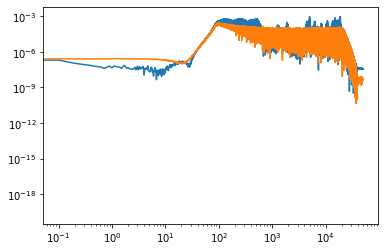

In [6]:
psd = psd_df(waveform_eq, fs)
plt.loglog(psd)
psd = psd_df(waveform_uneq, fs)
plt.loglog(psd)

In [73]:
from psi.controller import util
import importlib
importlib.reload(util)

result_silence = util.acquire(audio_engine, silence, speaker_channel_name, [mic_channel_name])
result_uneq = util.acquire(audio_engine, waveform_uneq, speaker_channel_name, [mic_channel_name])
result_eq = util.acquire(audio_engine, waveform_eq, speaker_channel_name, [mic_channel_name])

In [74]:
psd = psd_df(result_uneq[mic_channel_name][0], fs)
spl_uneq = mic_channel.calibration.get_spl(psd.columns, psd).mean(axis=0)

psd = psd_df(result_eq[mic_channel_name][0], fs)
spl_eq = mic_channel.calibration.get_spl(psd.columns, psd).mean(axis=0)

psd = psd_df(result_silence[mic_channel_name][0], fs)
spl_silence = mic_channel.calibration.get_spl(psd.columns, psd).mean(axis=0)

(50.0, 50000.0, 0.0, 64.63509876656553)

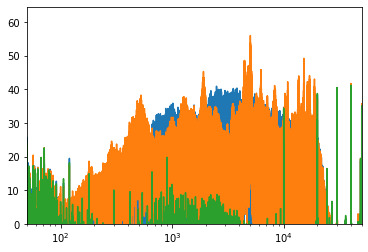

In [75]:
plt.semilogx(spl_uneq)
plt.axis(ymin=0, xmin=50, xmax=50000)
plt.semilogx(spl_eq)
plt.axis(ymin=0, xmin=50, xmax=50000)
plt.semilogx(spl_silence)
plt.axis(ymin=0, xmin=50, xmax=50000)

In [46]:
import numpy as np
from functools import partial
from psi.controller.api import ExtractEpochs, FIFOSignalQueue

epoch_input = ExtractEpochs(epoch_size=10)
epoch_input.add_callback(partial(accumulate, data))

queue = FIFOSignalQueue(fs=fs)
#queue.append(waveform_uneq, 1, 0)
silence = np.zeros_like(waveform_uneq)
queue.append(silence, 1, 0)
queue.connect(epoch_input.added_queue.append)

def accumulate(epochs, epoch):
    print('Capturing %d epochs', len(epoch))
    epochs.extend(epoch)

epochs = []
samples = []

speaker_channel.add_queued_epoch_output(queue, auto_decrement=True)
mic_channel.sync_start(speaker_channel)
mic_channel.add_input(epoch_input)
mic_channel.add_callback(samples.append)

audio_engine.configure()
audio_engine.start()

time.sleep(10)
    
audio_engine.stop()

In [47]:
mic_waveform = np.concatenate(samples)
mic_psd = psd_df(mic_waveform, fs)
mic_spl = mic_channel.calibration.get_spl(mic_psd.index, mic_psd.values)

(50.0, 50000.0, -20.0, 61.8438492286955)

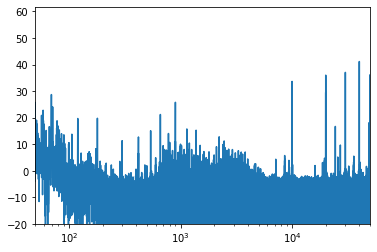

In [48]:
plt.semilogx(mic_psd.index, mic_spl)
plt.axis(xmin=50, xmax=50000, ymin=-20)

In [18]:
import time
while not epoch_input.complete:
    print('sleep')
    time.sleep(1)
audio_engine.stop()
    print(len(samples))
    

In [23]:
samples[0]

IndexError: list index out of range

In [11]:
data

[]